In [1]:
%load_ext memory_profiler


import os,sys

####################

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from Modules import *
from Modules_gula import *

import scipy.io
from datetime import datetime, timedelta

import xarray as xr

%matplotlib inline

no basemap module installed


In [2]:

mooring = 'osmosis'
season = 'spring'
#season = 'fall'
#season = 'summer'

#lat_moorings = [48.6875, 48.6780, 48.7000, 48.6940, 48.6803, 48.6290, 48.7485, 48.7480, 48.6290]
#lon_moorings = [-16.1875, -16.2050, -16.2060, -16.1730, -16.1740, -16.2775, -16.2762, -16.0945, -16.0990]

# Pick the central mooring
lat_mooring = 48.6290
lon_mooring = -16.0990


mydepths = [-500,-50]

simul = lambda: None
simul.f = 0.00010440225
simul.simul = 'osmosis'

####

def find_nearest(x,y,lon, lat):
    dist = (x-lon)**2 + (y-lat)**2
    return np.unravel_index(dist.argmin(),dist.shape)

####


In [3]:
# Osmosis data

##############
# Load data
##############

obs_osmo = scipy.io.loadmat('./Moorings/CTD_AQD_Center_mooring.mat')

p_osmo = -obs_osmo['pressure_aqd_Centre']

depths_osmo = np.mean(p_osmo[:,:],axis=1)+10
time_osmo = obs_osmo['mtime_Centre'][0,:]
dt_osmo = time_osmo[1]-time_osmo[0]

# from Callies et al: shallow = -51 m, deeper = -528 m
# from Yu et al: 50, 77, 109, 145, 168, 194, 228, 261, 10 299, 359, 405, 466, 527

#######
# Define dates
#######

if season=='fall':
    # for Osmosis:
    date1_osmo = datetime(2012, 10, 1)
    date2_osmo = datetime(2013, 1, 1)

elif season=='spring':
    date1_osmo = datetime(2013, 4, 1)
    date2_osmo = datetime(2013, 7, 1)

elif season=='summer':
    date1_osmo = datetime(2013, 6, 10)
    date2_osmo = datetime(2013, 10, 1)

    
origin_date = datetime(1,1,1) + timedelta(days=time_osmo[0]-365)

idate1 = np.int((date1_osmo - origin_date).days / dt_osmo)
idate2 = np.int((date2_osmo - origin_date).days / dt_osmo)

print(idate1,idate2)

if idate2>=len(time_osmo): idate2 = -1
    
print(season,datetime(1,1,1) + timedelta(days=time_osmo[idate1]-365),datetime(1,1,1) + timedelta(days=time_osmo[idate2]-365))

####

u_osmo = obs_osmo['u_aqd_Centre'][:,idate1:idate2]
v_osmo = obs_osmo['v_aqd_Centre'][:,idate1:idate2]
time_osmo = time_osmo[idate1:idate2]

k_osmo= np.array([12,0])


29663 42767
spring 2013-03-31 23:49:59.999996 2013-06-30 23:49:59.999996


## Parameters for spectra

In [4]:
import scipy.signal as sig
from scipy.fft import fft


    
###############

def myfft(y,Ts,unit='day'):
    '''
    Standard version using Welch's method with 30 days segments
    '''
    if unit=='day':
        nperseg = np.int(30/Ts) # 30 days
    elif unit=='s':
        nperseg = np.int(30*24*3600/Ts) # 30 days
        
    [freq,psd] = sig.welch(y,1./Ts,window='hanning',nperseg=nperseg)

    return freq,psd

###############

def myfft2(y,Ts,unit='day'):
    '''
    PSD using np.fft.rfft, with hanning window
    '''
    n = y.shape[0] # length of the signal

    hanning = 1
    if hanning == 1 : window = np.hanning(n)
    elif hanning == 0 : window = np.ones(n)

    #Compute PSD
    freq = np.fft.rfftfreq(n,Ts)
    psd = np.abs(np.fft.rfft((y-y.mean())*window))**2
    
    #normalize PSD
    psd *= Ts/n
    
    #compensate for variance reduction due to windowing
    psd /= (np.mean(window**2))

    return freq,psd

###############

def myfft3(y,Ts,unit='day'):
    '''
    PSD using np.fft.rfft, without windowing
    '''
    n = y.shape[0] # length of the signal

    hanning = 0
    if hanning == 1 : window = np.hanning(n)
    elif hanning == 0 : window = np.ones(n)

    #Compute PSD
    freq = np.fft.rfftfreq(n,Ts)
    psd = np.abs(np.fft.rfft((y-y.mean())*window))**2
    
    #normalize PSD
    psd *= Ts/n
    
    #compensate for variance reduction due to windowing
    psd /= (np.mean(window**2))

    return freq,psd

###############

def myfft4(y,Ts,unit='day'):
    '''
    PSD using scipy.fft, with hanning window
    '''
    n = y.shape[0] # length of the signal
    
    hanning = 1
    if hanning == 1 : window = np.hanning(n)
    elif hanning == 0 : window = np.ones(n)
        
    freq = np.arange(n)/(n*Ts) #*2*np.pi
    freq = freq[range(n//2)]
    Y= fft((y-y.mean())*window); 
    psd = (Y*np.conj(Y))[:n//2]/n*Ts
    
    #compensate for variance reduction due to windowing
    psd /= (np.mean(window**2))

    return freq,psd

###############


def myfft5(y,Ts,unit='day'):
    '''
    Roy's version
    '''
    n = y.shape[0] # length of the signal
    
    hanning = 1
    if hanning == 1 : window = np.hanning(n)
    else : window = np.ones(n)

    Y = fft( (y - y.mean()) * window*np.sqrt(8./3) )/n
    
    if n%2==0:                                                                                                     
        stop=n//2+1;                                                                                                      
    else:                                                                                                             
        stop=(n+1)//2;                                                                                                    
    
    psd = np.real(Y*np.conj(Y))[:stop]
    psd[1:] = 2.*psd[1:]
    psd *= n*Ts

    ###
    
    freq = np.arange(n)/(n*Ts) #*2*np.pi
    freq = freq[:stop]

    ###

    return freq,psd

###############
###############

def myfft6(y,Ts,unit='day'):
    '''
    PSD using np.fft.rfft, with hanning window
    '''
    n = y.shape[0] # length of the signal

    hanning = 1
    if hanning == 1 : window = np.hanning(n)
    elif hanning == 0 : window = np.ones(n)

    #Compute PSD
    freq = np.fft.rfftfreq(n,Ts)
    psd = np.abs(np.fft.rfft((y-y.mean())*window))**2
    
    #normalize PSD
    psd *= Ts/n
    
    #compensate for variance reduction due to windowing
    psd /= (np.mean(window**2))

    return freq,psd


In [5]:



###################################################################################

fontsize0 = 10
fontsize1 = 14
fontsize2 = format(18)
fontsize3 = format(26)
font = {'size'   : fontsize1}
plt.rc('font', **font)

###################################################################################

def myplot_time2(frq,frq2,frq3,frq4,frq5,frq6,fftemp,fftemp2,fftemp3,fftemp4,fftemp5,fftemp6,\
                 depth,unit='day',addname='_',label1=' ',label2=' ',label3=' ',label4=' ',label5=' ',label6=' '):
    plt.figure(figsize=(10.0,10.0)) 
    ax = plt.subplot2grid((3,1),(1, 0), rowspan=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(b=True, which='both', color='0.65',linestyle='-',linewidth=0.2)
    #####################
    colors = ['y','b','g']
    colors_seas = ['r','y','c','b','g','k']  
    ###############################
    if unit=='day':
        plt.xlabel('Freq [cpday]')
        varunit = 'PSD [m$^2$ s$^{-2}$ cpday$^{-1}$]'
        conv = 1.
    elif unit=='s':
        plt.xlabel('Freq [cps]')
        varunit = 'PSD [m$^2$ s$^{-2}$ cps$^{-1}$]'
        conv = 24.*3600.
    ###############################
    #bnds = [1/7.,1.] #sections for least square fit  
    #ibnds = [np.nanargmin(np.abs(frq-bnd)) for bnd in bnds]
    ###############################
    plot3, = plt.plot(frq3[1:],fftemp3[1:],'-',linewidth=3.,color=colors_seas[2],alpha=0.5) # plotting the spectrum
    plot4, = plt.plot(frq4[1:],fftemp4[1:],'-*',linewidth=1.,color=colors_seas[3],alpha=0.5) # plotting the spectrum
    ###############################
    plot5, = plt.plot(frq5[1:],fftemp5[1:],'-x',linewidth=2.,color=colors_seas[5],alpha=0.5) # plotting the spectrum
    plot6, = plt.plot(frq6[1:],fftemp6[1:],'-',linewidth=1.,color=colors_seas[4],alpha=0.5) # plotting the spectrum
    plot1, = plt.plot(frq[1:],fftemp[1:],'-',linewidth=5.,color=colors_seas[0]) # plotting the spectrum
    plot2, = plt.plot(frq2[1:],fftemp2[1:],'-',linewidth=3.,color=colors_seas[1],alpha=.5) # plotting the spectrum

    ################################
    plt.ylabel(varunit,fontsize='18'); 
    #ax.set_xlim([1./360./5.,48./0.5])
    ax.set_xlim([0.2e-1/conv,13/conv])
    ylim = [1e-8*conv,1e2*conv]
    ax.set_ylim(ylim)
    #####################
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ticks = [1/7./conv,1./conv,24./conv]
    #ticks = [1/360.,1/30.,1/7.,1.,24.]
    ax2.set_xticks(ticks)
    for i in range(len(ticks)): 
        plt.plot((ticks[i],ticks[i]),ax2.get_ylim(),'-k',linewidth=0.5)
    locs, labels = plt.xticks()
    labels = ['week', 'day','hour']
    #labels = ['year','month','week', 'day','hour']
    new_labels = [x.format(locs[i]) for i,x  in enumerate(labels)]
    plt.xticks(locs, new_labels, fontsize = fontsize1)
    ax2.set_xbound(ax.get_xbound())
    #ax2.set_ybound(ax.get_ybound())
    ax2.set_xlabel(r"Period")
    ax2.set_ylim(ylim)
    #####################
    # tidal periods
    tide_names = [r'$K_1$',r'$O_1$',r'$f+M_2$',r'$S_2$',r'$M_2$',r'$2M_2$']
    M2 = 24./12.420599937439/conv
    K1 = 24./23.9344997406006/conv
    S2 = 24./12./conv
    O1 = 24./25.819299697876/conv
    f = simul.f*24.*3600./(2*np.pi)/conv
    tide_period = [K1,O1,f+M2,S2,M2,2*M2]
    horizontalalignment = ['left','right','center']
    verticalalalignment = ['top','top','bottom','top','top','top']
    if 'tides' in simul.simul or 'osmosis' in simul.simul or 'luckyt' in simul.simul or 'chabat' in simul.simul or 'midcal' in simul.simul:
        for it,tname in enumerate(tide_names):
            if tide_period[it]<ax2.get_xlim()[-1]:
                ax.plot((tide_period[it],tide_period[it]),(np.nanmax([ax2.get_ylim()[0],ax2.get_ylim()[-1]*1e-3]),ax2.get_ylim()[-1]*0.07),'-',color='grey',linewidth=1.)
                ax.text(tide_period[it],0.3*ax2.get_ylim()[-1],tname,color='grey',fontsize=fontsize0, horizontalalignment=horizontalalignment[it%3], verticalalignment=verticalalalignment[it])
    ###########
    # inertial period
    tide_names = [r'$f$']
    #f = simul.f.mean()*24.*3600./(2*np.pi)/conv
    tide_period = [f]
    for it,tname in enumerate(tide_names):
        if tide_period[it]<ax2.get_xlim()[-1]:
            ax.plot((tide_period[it],tide_period[it]),(ax2.get_ylim()[0],ax2.get_ylim()[-1]*0.1),'-',color='DarkBlue',linewidth=1.)
            ax.text(tide_period[it],0.93*ax2.get_ylim()[-1],tname,color='DarkBlue',fontsize=fontsize2, horizontalalignment='center', verticalalignment='top')
    ###########
    # daily cycle
    '''
    tide_names = [r'$d$',r'$2d$',r'$3d$',r'$4d$']
    d = 1.
    tide_period = [d,2*d,3*d,4*d]
    for it,tname in enumerate(tide_names):
        if tide_period[it]<ax2.get_xlim()[-1]:

            ax.plot((tide_period[it],tide_period[it]),(ax2.get_ylim()[0],ax2.get_ylim()[-1]*0.007),'-',color='Orange',linewidth=1.)
            ax.text(tide_period[it],0.01*ax2.get_ylim()[-1],tname,color='Orange',fontsize=fontsize1, horizontalalignment='center', verticalalignment='top')
    '''
    #####################
    legend = plt.legend([plot1,plot2,plot3,plot4,plot5,plot6], [label1,label2,label3,label4,label5,label6],
                            bbox_to_anchor=(0.05, 0.05),loc=3, borderaxespad=0.,fontsize = fontsize1)
    legend.get_frame().set_facecolor('w')
    #####################
    plt.text(0.1,0.9,'z='+format(np.int(depth))+' m - '+ season,fontsize=fontsize2,horizontalalignment='left', transform=ax.transAxes)
    #####################
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    #####################
    plt.savefig('./osmosis_time_spectra' + '_all_' + simul.simul + '_' + season +  '_z' + format(np.int(-depth)) + addname +  '.png',dpi=300,bbox_inches='tight')
    #plt.clf(); plt.close()


########################################
    


0 -500
obs -528.5377455514624


/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 -50
obs -47.35053067924825


/home/gula/.virtualenvs/paragridded/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


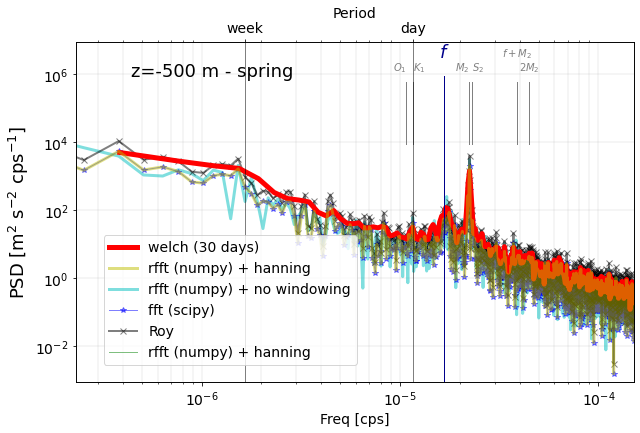

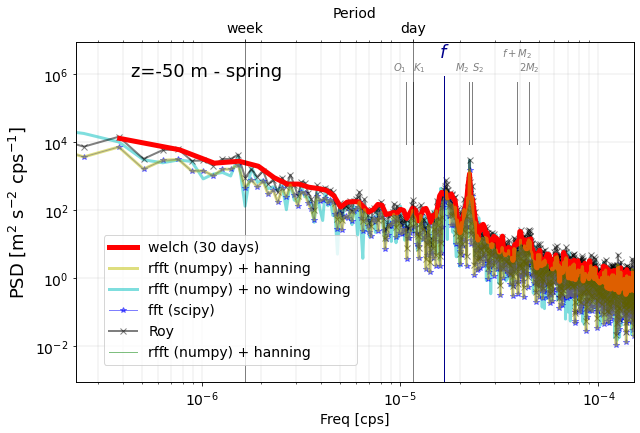

In [6]:

unit = 's'

for k,mydepth in enumerate(mydepths):
    
    print(k,mydepth)
    print('obs',depths_osmo[k_osmo[k]])  
    
    if unit=='s':
        conversion=24.*3600
    elif unit=='day':
        conversion=1
    
 
    ###############
    # osmosis (time in days)

    frq_osmo,fftempu_osmo = myfft(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo,fftempv_osmo = myfft(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo = 0.5* (fftempu_osmo + fftempv_osmo)

 
    ###############
    # osmosis (time in days)

    frq_osmo2,fftempu_osmo2 = myfft2(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo2,fftempv_osmo2 = myfft2(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo2 = 0.5* (fftempu_osmo2 + fftempv_osmo2)
    
 
    ###############
    # osmosis (time in days)

    frq_osmo3,fftempu_osmo3 = myfft3(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo3,fftempv_osmo3 = myfft3(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo3 = 0.5* (fftempu_osmo3 + fftempv_osmo3)
    
 
    ###############
    # osmosis (time in days)

    frq_osmo4,fftempu_osmo4 = myfft4(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo4,fftempv_osmo4 = myfft4(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo4 = 0.5* (fftempu_osmo4 + fftempv_osmo4)
    
    ###############
    # osmosis (time in days)

    frq_osmo5,fftempu_osmo5 = myfft5(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo5,fftempv_osmo5 = myfft5(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo5 = 0.5* (fftempu_osmo5 + fftempv_osmo5)

    ###############
    # osmosis (time in days)

    frq_osmo6,fftempu_osmo6 = myfft6(u_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);
    frq_osmo6,fftempv_osmo6 = myfft6(v_osmo[k_osmo[k],:],dt_osmo*conversion,unit=unit);

    fftemp_osmo6 = 0.5* (fftempu_osmo6 + fftempv_osmo6)
                          
    ###############

    myplot_time2(frq_osmo,frq_osmo2,frq_osmo3,frq_osmo4,frq_osmo5,frq_osmo6,\
                 fftemp_osmo,fftemp_osmo2,fftemp_osmo3,fftemp_osmo4,fftemp_osmo5,fftemp_osmo6*0.,\
                 mydepth,unit=unit,\
                 label1='welch (30 days)', label2 = 'rfft (numpy) + hanning',\
                 label3 ='rfft (numpy) + no windowing', label4 ='fft (scipy)', label5 ='Roy', label6 ='rfft (numpy) + hanning',
                 addname ='normalization')
    


